In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
from google.colab import drive
import numpy as np
import cv2

## Mounting Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Constant Variables

In [ ]:
csv_file = '/content/gdrive/MyDrive/Projects/Hive Network for autonomous car/src/original_data/dataset_l_r.csv'
img_root = '/content/gdrive/MyDrive/Projects/Hive Network for autonomous car/src/original_data'
model_path = '/content/gdrive/MyDrive/Projects/Hive Network for autonomous car/src/Models/Model_2'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [ ]:
# Helper Functions

def canny(image, t1=50, t2=150):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, t1, t2)
    return canny

def sharpen_image(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened


def cut_lane_region(image):
    return image[150:, :, :]


def convert_to_numpy_array(image):
  return np.array(image)


def convert_to_pil_image(image):
  return Image.fromarray(image)



In [ ]:
# Define the dataset
class LaneDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.lane_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.lane_frame)

    def __getitem__(self, idx):
        img_path = self.lane_frame['file'][idx]
        img_path =  f'{img_root}/{img_path}'
        image = Image.open(img_path).convert('RGB')
        label = self.lane_frame.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the transforms operation
transform = transforms.Compose([
    transforms.Lambda(convert_to_numpy_array),
    transforms.Lambda(cut_lane_region),
    transforms.Lambda(sharpen_image),
    transforms.Lambda(canny),
    transforms.Lambda(convert_to_pil_image),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Define the dataset and dataloader
lane_dataset = LaneDataset(csv_file=csv_file, transform=transform)
batch_size = 32
lane_dataloader = DataLoader(lane_dataset, batch_size=batch_size, shuffle=True)

# Model and training

In [ ]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Training Loop

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training loop
def train(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f'epoch: {epoch}')
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Train the model
num_epochs = 10
train(model, lane_dataloader, criterion, optimizer, num_epochs)

epoch: 0
Epoch 1/10, Loss: 0.6816, Accuracy: 58.14%
epoch: 1
Epoch 2/10, Loss: 0.6552, Accuracy: 59.84%
epoch: 2
Epoch 3/10, Loss: 0.5740, Accuracy: 65.22%
epoch: 3
Epoch 4/10, Loss: 0.5010, Accuracy: 72.57%
epoch: 4
Epoch 5/10, Loss: 0.4489, Accuracy: 78.61%
epoch: 5
Epoch 6/10, Loss: 0.3639, Accuracy: 84.91%
epoch: 6
Epoch 7/10, Loss: 0.3093, Accuracy: 86.35%
epoch: 7
Epoch 8/10, Loss: 0.2774, Accuracy: 88.98%
epoch: 8
Epoch 9/10, Loss: 0.2872, Accuracy: 88.71%
epoch: 9
Epoch 10/10, Loss: 0.2730, Accuracy: 88.32%


# Testing

In [ ]:
# model = torch.load(model_path)

In [ ]:
df = pd.read_csv(csv_file)

In [ ]:
# sorted(df[df['file'].str.startswith('t7/')]['file'].map(lambda x: int(x.split('/')[1].split('.jpg')[0])).to_list())

[1]


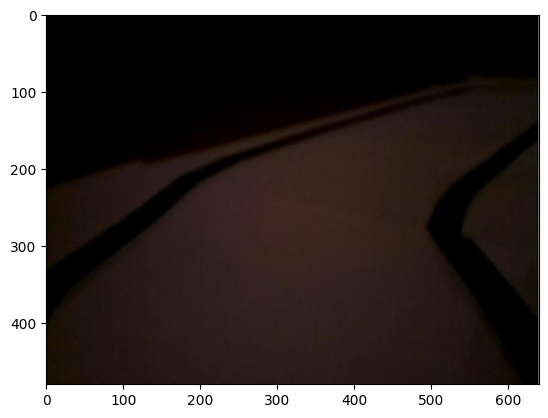

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

file_path = 't7/64.jpg'

image = Image.open(f'{img_root}/{file_path}').convert('RGB')

image_tr = transform(image)
print(model(image_tr.unsqueeze(dim=0).to(device)).argmax(dim=1).cpu().numpy())
# print(df[df['file'] == file_path])

plt.imshow(image)

# Validating

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score

ground_truth = pd.read_csv(csv_file)


In [ ]:
import os
l = []

for img in ground_truth['file']:
  image = Image.open(f'{img_root}/{img}').convert('RGB')
  image_tr = transform(image)
  l.append((f'{img}', model(image_tr.unsqueeze(dim=0).to(device)).argmax(dim=1).cpu().numpy()[0]))

In [ ]:
pred = pd.DataFrame(l, columns=['file', 'r'])

In [ ]:
print(f"Accuracy: {accuracy_score(ground_truth['r'], pred['r'])}")
print(f"Precision: {precision_score(ground_truth['r'], pred['r'])}")
print(f"Recall: {recall_score(ground_truth['r'], pred['r'])}")
print(f"R2: {r2_score(ground_truth['r'], pred['r'])}")

Accuracy: 0.9068241469816273
Precision: 0.9175704989154013
Recall: 0.9276315789473685
R2: 0.6122721018231854


<Axes: >

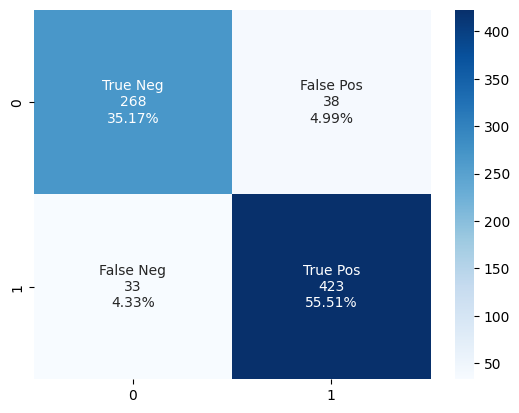

In [ ]:
import seaborn as sns


cf_matrix = confusion_matrix(ground_truth['r'], pred['r'])

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

# Saving Model

In [ ]:
torch.save(model, model_path)
# model = torch.load(model_path)
